In [1]:
from deeplabv3 import DeepLabV3
from unet import UNet
from unetplusplus import UNetPlusPlus
from dataset import CVDataset
from metrics import IoU_torch, f1_scores
from inference_dataset import CVInferenceDataset

from torch.utils.data import DataLoader
from os import cpu_count
from torch import no_grad
from torch.cuda import is_available as cuda_is_available
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
import torch
from torch import tensor, cuda, is_tensor, float32, long, from_numpy
import matplotlib.pyplot as plt
import gc
from numpy import array
import os
import shutil

device = 'cuda' if cuda_is_available() else 'cpu'
num_epochs = 5
batch_size = 3


data_train = CVInferenceDataset('/home/jupyter/datasphere/project/satellite_hack/', 1, True, (1024,1024))
data_valid = CVInferenceDataset('/home/jupyter/datasphere/project/satellite_hack/', 1, False, (1024,1024))
weight_loss = [1., 1., 1., 1.]
def visual_graphic(list_res_model):
    '''
    model:
        epoch:
            k:
                k, train_loss, val_loss, val_two_score, val_one_score
    '''
    '''
    epoch1:
        model:
            k...
    epoch2:
    ...
    '''
    model_names = list(list_res_model.keys())
    model_values = list(list_res_model.values())
    for i in range(len(model_values[0])):
        '''
        Создаем фигуру для определенной эпохи и рисуем для каждой модели ее скор в определенную итерацию, рисуем график, сохраняем
        '''
        if os.path.exists(f"/home/jupyter/datasphere/project/satellite_hack/model/graphic_res/{i+1}epochs"): 
            shutil.rmtree(f"/home/jupyter/datasphere/project/satellite_hack/model/graphic_res/{i+1}epochs")
        os.makedirs(f"/home/jupyter/datasphere/project/satellite_hack/model/graphic_res/{i+1}epochs")
        k = model_values[0][i][0]
        plt.figure(figsize=(16, 9))
        plt.title('Loss')
        for j in range(len(model_names)):
            y1 = model_values[j][i][1]
            y2 = model_values[j][i][2]
            plt.plot(k, y1, label=f'train {model_names[j]}')
            plt.plot(k, y2, label=f'val {model_names[j]}')
            plt.legend(bbox_to_anchor=(0.98, 1), loc='upper left')
        plt.savefig(f"/home/jupyter/datasphere/project/satellite_hack/model/graphic_res/{i+1}epochs/loss.png")
        plt.figure(figsize=(16, 9))
        plt.title("Score")
        for j in range(len(model_names)):
            y1 = model_values[j][i][4]
            y2 = model_values[j][i][3]
            plt.plot(k, y1, label=f'build {model_names[j]}')
            plt.plot(k, y2, label=f'back {model_names[j]}')
            plt.legend(bbox_to_anchor=(0.98, 1), loc='upper left')
        plt.savefig(f"/home/jupyter/datasphere/project/satellite_hack/model/graphic_res/{i+1}epochs/score.png")

def calculate_valid(model_names, model, data, criterion, score):
    val_los = 0
    val_score_mean = 0
    val_score_one = 0
    count_n = 0
    with no_grad():
        dat = data[0]
        count_n = len(dat)
        loader = DataLoader(dat, batch_size=batch_size, shuffle=False, num_workers=cpu_count(), pin_memory=False)
        for x, y in loader:
            images, targets = x.to(device), y.to(device)
            optim.zero_grad()
            output = model(images)
            if model_names != 'unetSV++':
                loss = criterion(output, targets)
            else:
                loss = criterion[0](output[0], targets) * weight_loss[0]
                for i in range(1, 4):
                    loss += criterion[i](output[i], targets) * weight_loss[i]
                output = output[-1]
            for i in range(len(output)):
                out = output[i].detach().cpu()
                data.imshow(images[i].detach().cpu(), targets[i].detach().cpu(), out, f'test{i}')
                val_los += loss.item()
            val_score_mn, val_score_on = score(output.detach().cpu(), targets.detach().cpu())
            val_score_mean += val_score_mn * batch_size
            val_score_one += val_score_on * batch_size
    return val_los / count_n, val_score_mean / count_n, val_score_one / count_n

def clear_cuda_memory():
    cuda.empty_cache()

    for obj in gc.get_objects():
        try:
            if is_tensor(obj) and obj.is_cuda:
                del obj
        except Exception as e:
            pass
    
    gc.collect()
    cuda.empty_cache()


list_model = {
              # 'unet': UNet(3, 2),
              # 'unetSV++': UNetPlusPlus(2, 3, deep_supervision=True),
              # 'unet++': UNetPlusPlus(2, 3, deep_supervision=False),
              'deeplab': DeepLabV3(2)
              }
list_res_model = {}

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /tmp/xdg_cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:04<00:00, 61.1MB/s] 


100%|██████████| 5/5 [2:04:43<00:00, 1496.68s/it]
/usr/local/lib/python3.10/dist-packages/torch/distributed/distributed_c10d.py:293: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


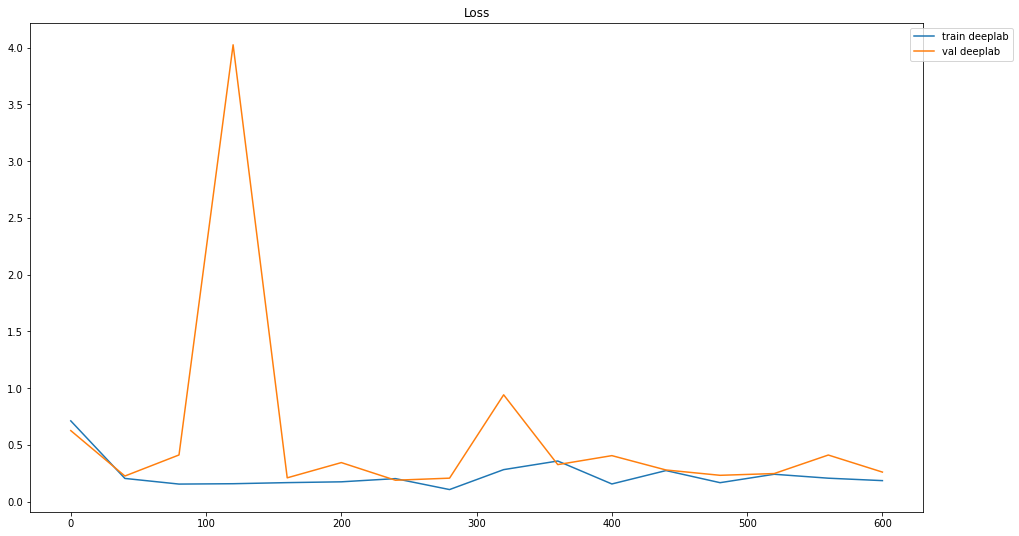

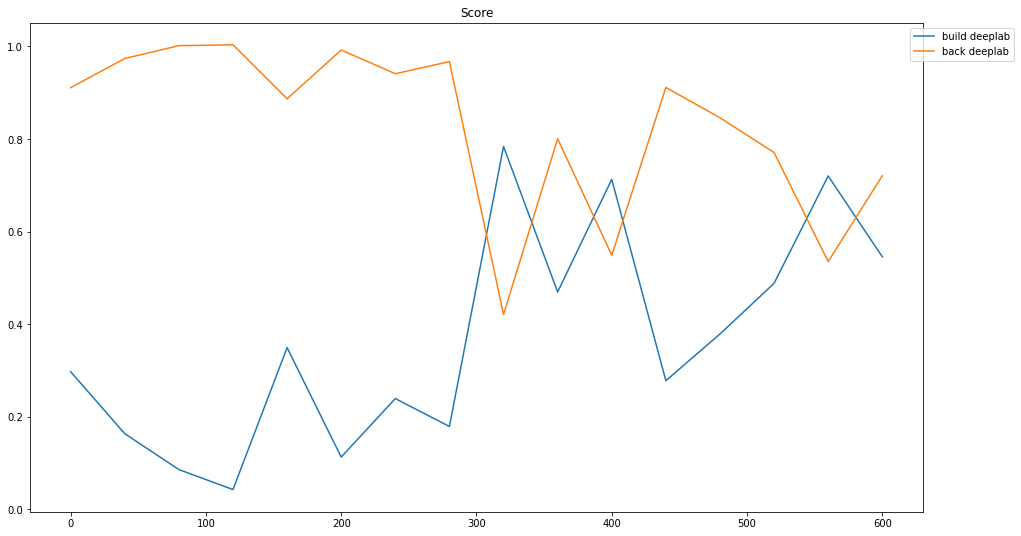

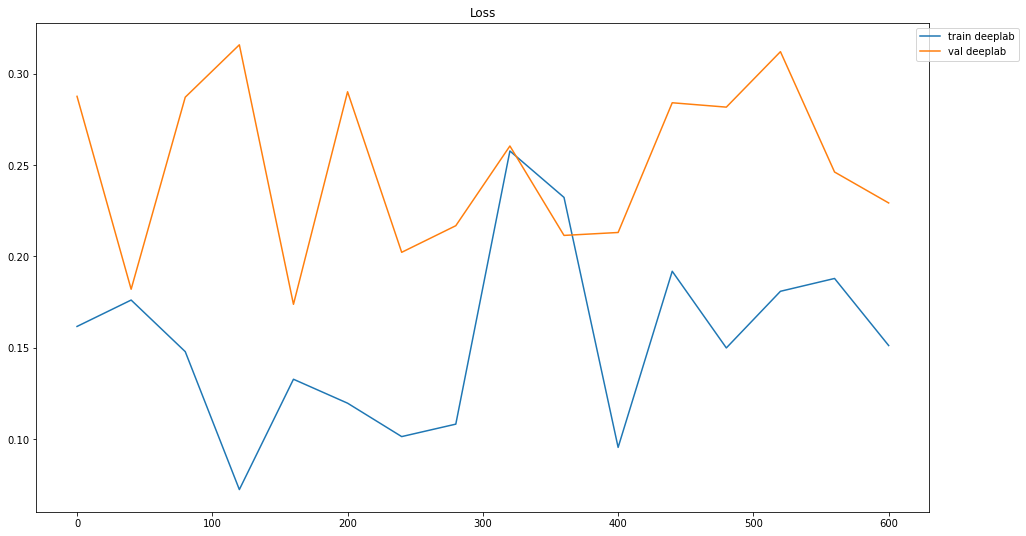

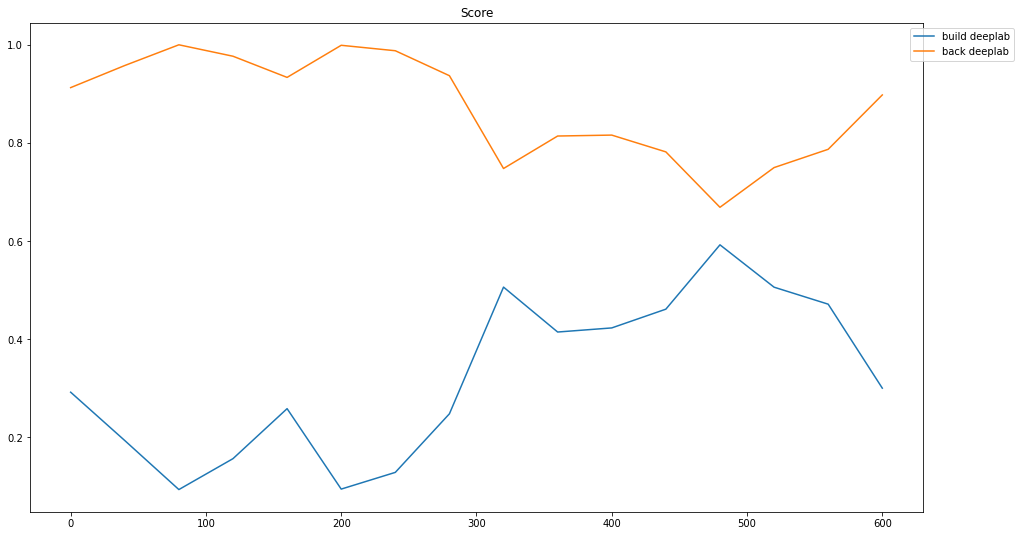

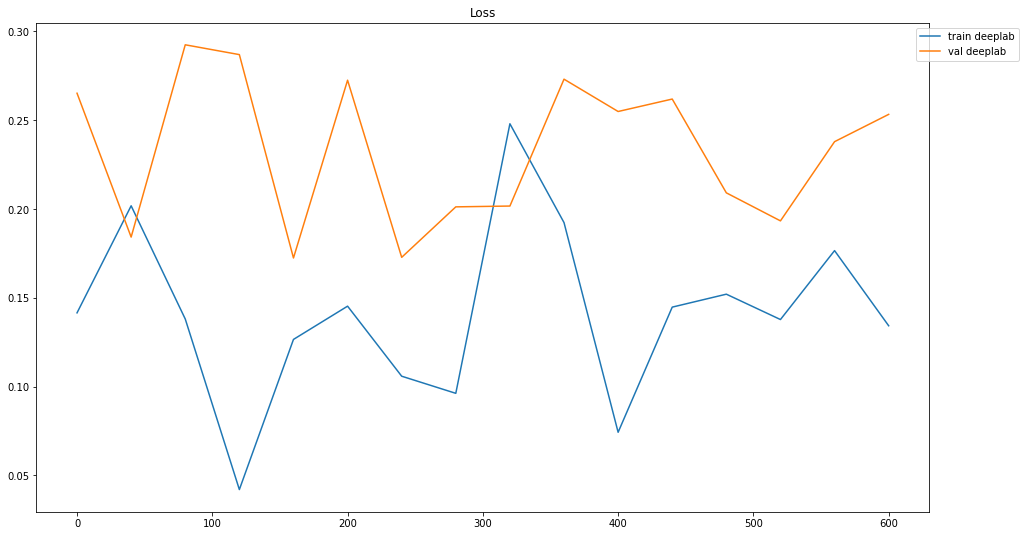

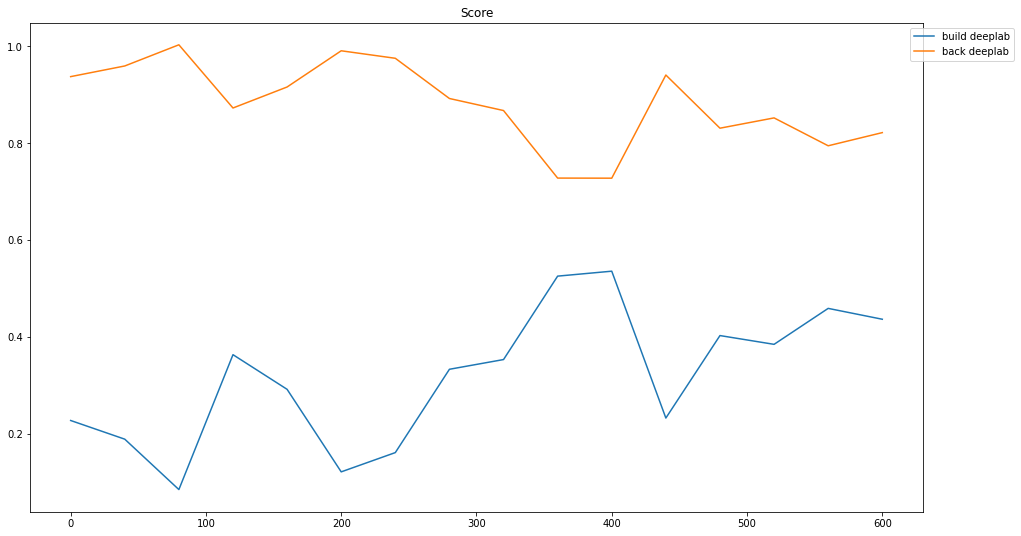

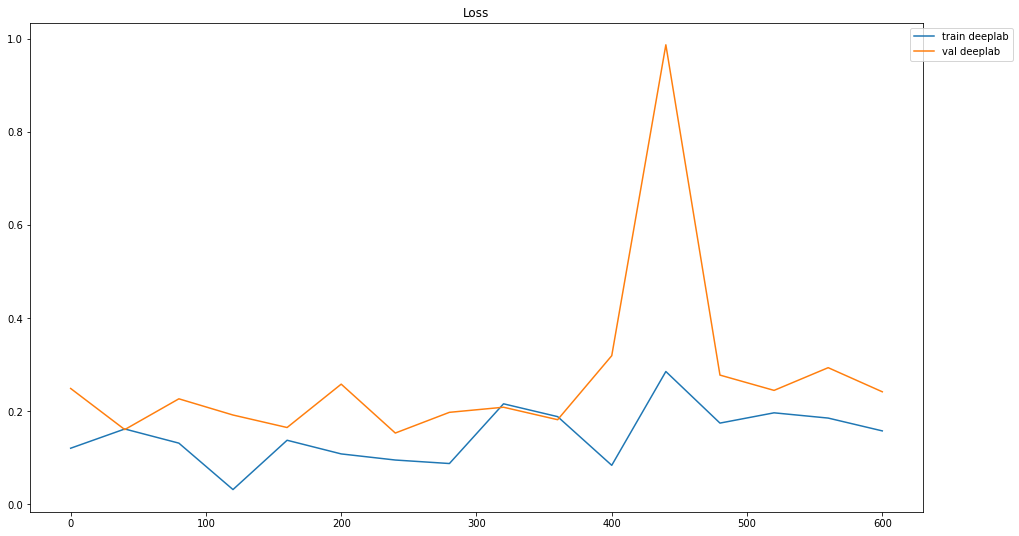

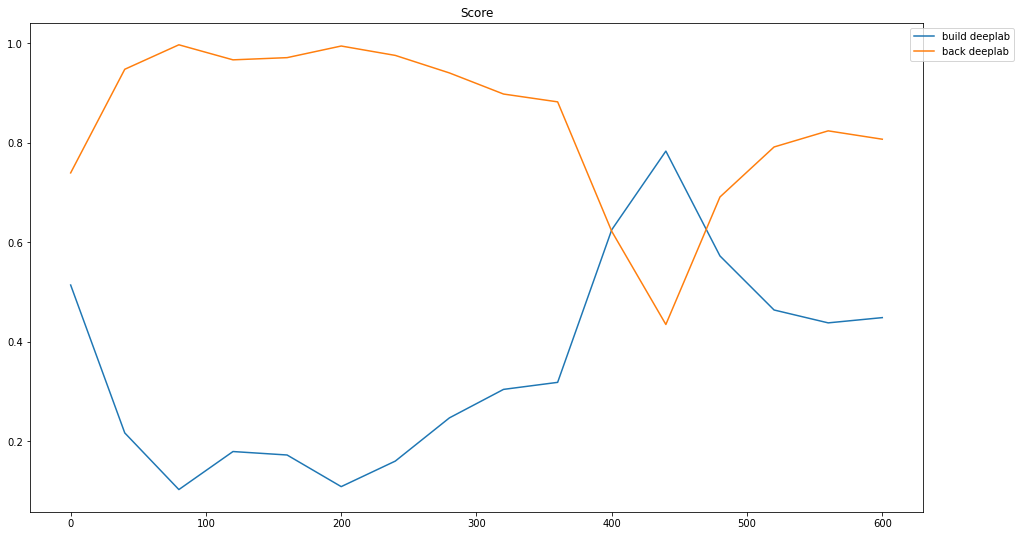

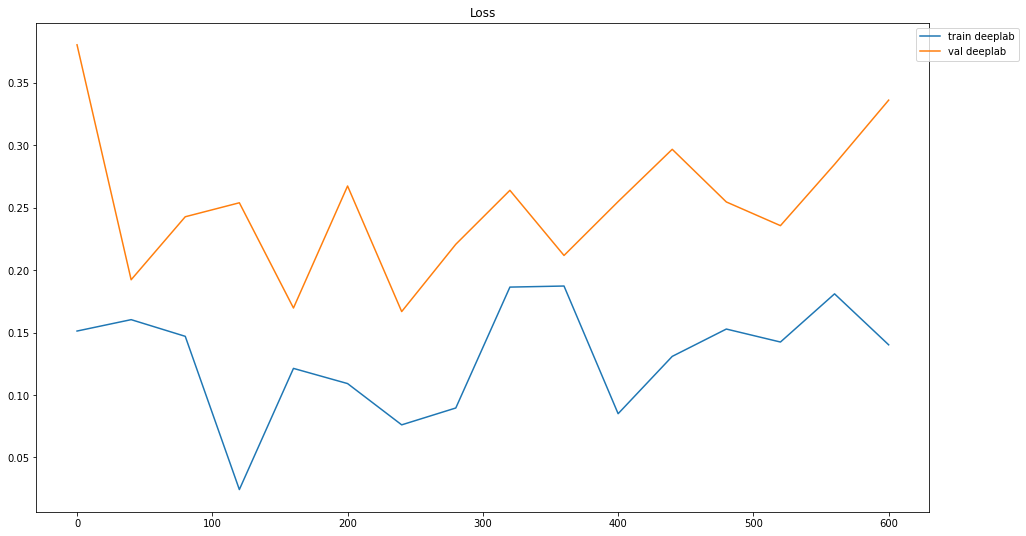

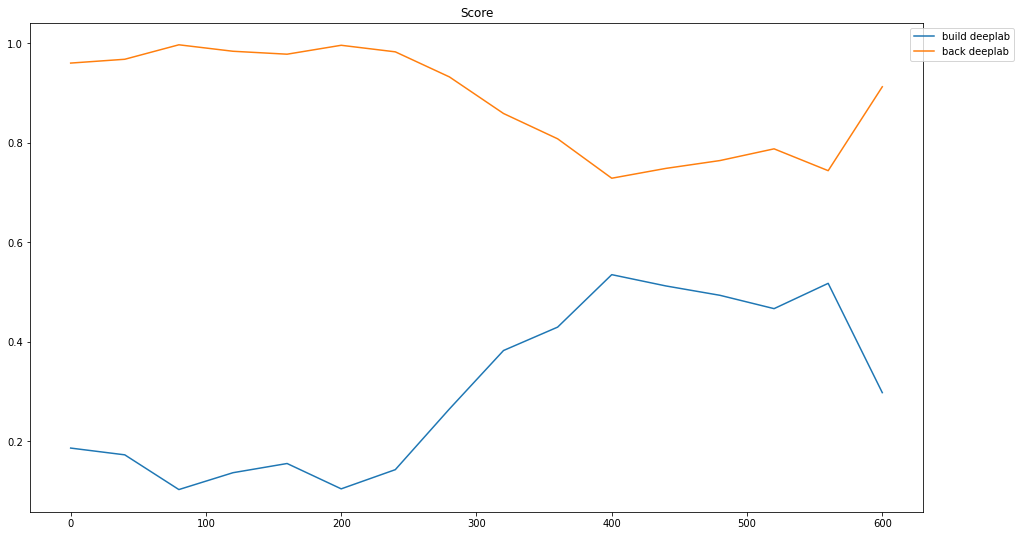

In [2]:
for model_names in list_model.keys():
    model = list_model[model_names].to(device)
    criterion = [CrossEntropyLoss(weight=tensor([100., 1.], device=device),reduction='mean') for _ in range(4)]
    if model_names != 'unetSV++':
        criterion = criterion[0]
    optim = Adam(model.parameters(), lr=3e-4)
    score = f1_scores
    model.train()
    epoch_result = []
    for _ in tqdm(range(num_epochs)):
        graphic_val_loss = []
        graphic_val_two_accuracy = []
        graphic_val_one_accuracy = []
        graphic_train_loss = []
        list_k = []
        
        sum_k = 0
        for k, data in enumerate(tqdm(data_train)):
            loader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=cpu_count(), pin_memory=False)
            for x, y in loader:
                images, targets = x.to(device), y.to(device)
                optim.zero_grad()
                output = model(images)
                if model_names != 'unetSV++':
                    loss = criterion(output, targets)
                else:
                    loss = criterion[0](output[0], targets) * weight_loss[0]
                    for i in range(1, 4):
                        loss += criterion[i](output[i], targets) * weight_loss[i]
                loss.backward()
                optim.step()
                if sum_k % 40 == 0:
                    model.eval()
                    val_los, val_score_one, val_score_two = calculate_valid(model_names, model, data_valid, criterion, score)
                    model.train()
                    list_k.append(sum_k)
                    graphic_train_loss.append(loss.item())
                    graphic_val_loss.append(val_los)
                    graphic_val_two_accuracy.append(val_score_two)
                    graphic_val_one_accuracy.append(val_score_one)
                sum_k += 1
            del loader
        epoch_result.append((list_k, graphic_train_loss, graphic_val_loss, graphic_val_two_accuracy, graphic_val_one_accuracy))
    model = model.to('cpu')
    torch.save(model.state_dict(), f'/home/jupyter/datasphere/project/satellite_hack/model_{model_names}.pth')
    del model, criterion, optim, score
    clear_cuda_memory()
    list_res_model[model_names] = epoch_result

visual_graphic(list_res_model)

In [ ]:
model = list_model['deeplab'].to('cpu')
torch.save(model.state_dict(), '/home/jupyter/datasphere/project/satellite_hack/model.pth')

In [ ]:
visual_graphic(list_res_model)